# ***Libraries***

In [1]:
import math
import os
import sys
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
sys.path.append(parent_dir)

In [4]:
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length, plotFig, printResult

from TSB_UAD.models.iforest import IForest

# ***Naive-Streaming Methods***
TODO: Add comments

## ***Data Pre-Processing***

In [5]:
# Load the Time-Series dictionary
with open('Time-Series-Data-Dictionary.json', 'r') as json_file:
    loaded_dict = json.load(json_file)

In [6]:
for filename, info in loaded_dict.items():
    print(f'{filename}: {info}')

ts1: ['Normality_1', 'MGAB']
ts2: ['Normality_2', 'SVDB', 'Dodgers']
ts3: ['Normality_2', 'SMD', 'Dodgers']
ts4: ['Normality_1', 'Daphnet']
ts5: ['Normality_1', 'NAB']
ts6: ['Normality_2', 'KDD21', 'GHL']
ts7: ['Normality_3', 'MITDB', 'IOPS', 'Occupancy']
ts8: ['Normality_1', 'ECG']
ts9: ['Normality_1', 'NASA-MSL']
ts10: ['Normality_2', 'Occupancy', 'NAB']
ts11: ['Normality_3', 'SVDB', 'IOPS', 'Occupancy']
ts12: ['Normality_3', 'Genesis', 'IOPS', 'SensorScope']
ts13: ['Normality_3', 'Occupancy', 'Dodgers', 'SensorScope']
ts14: ['Normality_2', 'GHL', 'SMD']
ts15: ['Normality_3', 'SVDB', 'ECG', 'SensorScope']


In [7]:
preprocessed_dict = {}

In [8]:
from more_itertools import chunked

# Set the number of windows to be fit per batch.
windows_per_batch = 200

for filename, info in loaded_dict.items():
    ts_filepath = f"TS-Data-Files/{filename}"
    
    # === Pre-processing steps ===

    # Prepare data for unsupervised method
    ts = pd.read_csv(ts_filepath, header=None).dropna().to_numpy()

    name = ts_filepath.split('/')[-1]
    max_length = ts.shape[0]

    data = ts[:max_length, 0].astype(float)
    label = ts[:max_length, 1]

    slidingWindow = find_length(data)
    X_data = Window(window=slidingWindow).convert(data).to_numpy()

    # Take the series and batch it.
    batched_data = []
    i = 0
    while i < len(data):
        # print(len(data), i, i+slidingWindow+windows_per_batch, len(data[i:i+slidingWindow+windows_per_batch]))
        batched_data.append(data[i:i+slidingWindow+windows_per_batch - 1])
        i += windows_per_batch
        if i+slidingWindow+windows_per_batch > len(data):
            batched_data.append(data[i:min(i+slidingWindow+windows_per_batch - 1, len(data))])
            # print('end', len(data), i, i+slidingWindow+windows_per_batch, len(data[i:i+slidingWindow+windows_per_batch]))
            break
        # print(len(data), i, i+slidingWindow+windows_per_batch, len(data[i:i+slidingWindow+windows_per_batch]))

        
    # Take the windows and batch them.
    batched_X_data = [np.array(list(batch)) for batch in chunked(X_data, windows_per_batch)]

    # Prepare data for semisupervised method. 
    # Here, the training ratio = 0.1

    data_train = data[:int(0.1 * len(data))]
    data_test = data

    X_train = Window(window=slidingWindow).convert(data_train).to_numpy()
    X_test = Window(window=slidingWindow).convert(data_test).to_numpy()

    print(f'Time-Series filename: {filename}')
    print("Estimated Subsequence length: ", slidingWindow)
    print()
    
    # Store the pre-processed variables in the new dictionary
    preprocessed_dict[filename] = {
        'name': name,
        'data': data,
        'batched_data': batched_data,
        'label': label,
        'slidingWindow': slidingWindow,
        'X_data': X_data,
        'batched_X_data': batched_X_data,
        'data_train': data_train,
        'data_test': data_test,
        'X_train': X_train,
        'X_test': X_test,
        'Time series length': len(data),
        'Number of abnormal points': list(label).count(1)
    }

Time-Series filename: ts1
Estimated Subsequence length:  125

Time-Series filename: ts2
Estimated Subsequence length:  125

Time-Series filename: ts3
Estimated Subsequence length:  125

Time-Series filename: ts4
Estimated Subsequence length:  24

Time-Series filename: ts5
Estimated Subsequence length:  125

Time-Series filename: ts6
Estimated Subsequence length:  125

Time-Series filename: ts7
Estimated Subsequence length:  24

Time-Series filename: ts8
Estimated Subsequence length:  122

Time-Series filename: ts9
Estimated Subsequence length:  125

Time-Series filename: ts10
Estimated Subsequence length:  125

Time-Series filename: ts11
Estimated Subsequence length:  72

Time-Series filename: ts12
Estimated Subsequence length:  125

Time-Series filename: ts13
Estimated Subsequence length:  88

Time-Series filename: ts14
Estimated Subsequence length:  288

Time-Series filename: ts15
Estimated Subsequence length:  36



In [9]:
len(preprocessed_dict['ts1']['batched_X_data'][-1])

32

In [10]:
len(preprocessed_dict['ts1']['batched_data'][-1])

156

In [11]:
65+65

130

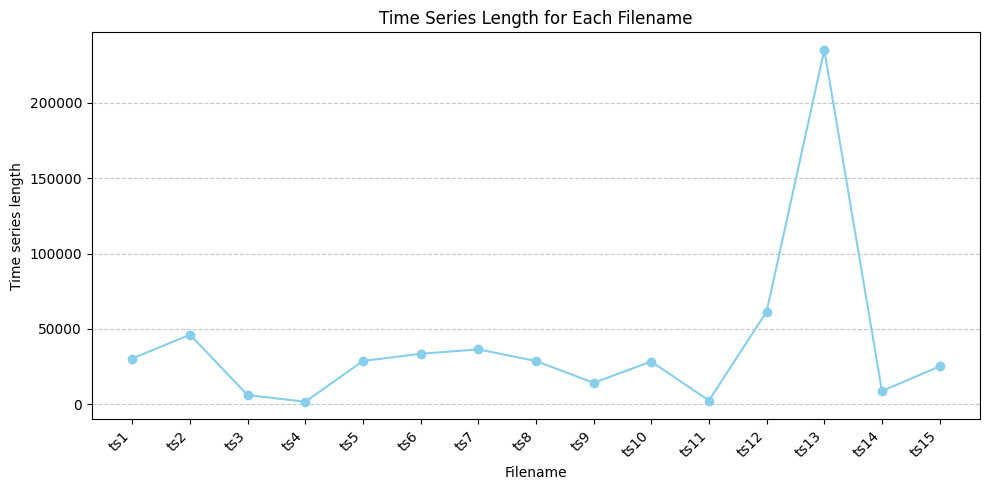

In [12]:
# Get filenames, time series lengths, and number of abnormal points
filenames = list(preprocessed_dict.keys())
time_series_lengths = [data['Time series length'] for data in preprocessed_dict.values()]
number_of_abnormal_points = [data['Number of abnormal points'] for data in preprocessed_dict.values()]

# Plot 'Time series length' and 'Number of abnormal points' for each filename
plt.figure(figsize=(10, 5))
plt.plot(filenames, time_series_lengths, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Filename')
plt.ylabel('Time series length')
plt.title('Time Series Length for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

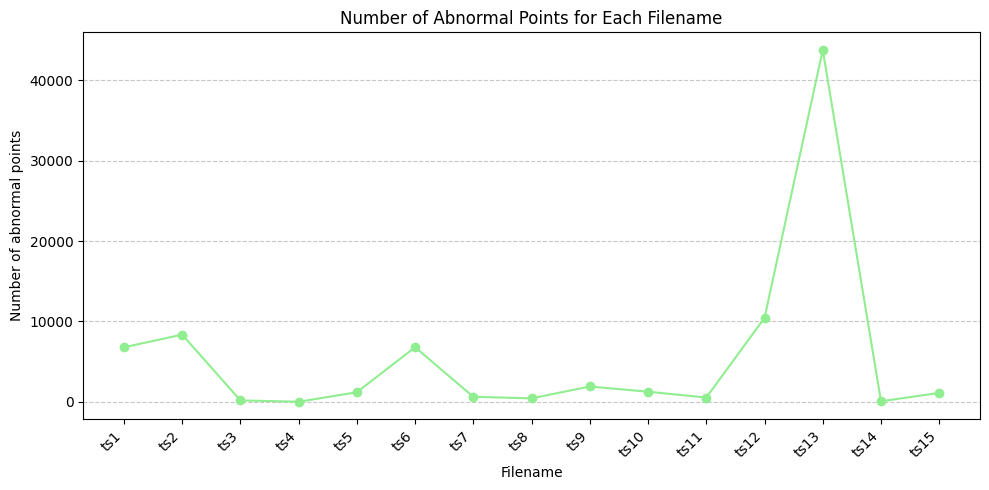

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(filenames, number_of_abnormal_points, marker='o', linestyle='-', color='lightgreen')
plt.xlabel('Filename')
plt.ylabel('Number of abnormal points')
plt.title('Number of Abnormal Points for Each Filename')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## ***Anomaly Detection***

### ***Isolation Forest***

In [14]:
from tqdm.notebook import tqdm_notebook as tqdm

modelName = 'IForest'
clf = IForest(n_jobs=10)

In [15]:
results = []

for filename in tqdm(preprocessed_dict.keys(), desc='Processing Time Series'):
    ts = preprocessed_dict[filename]
    x = ts['X_data']
    
    score = []
    for batch in tqdm(ts['batched_X_data'], desc='Processing Batch'):
        clf.fit(batch)
        score.extend(clf.decision_scores_)
    
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((ts['slidingWindow']-1)/2) + list(score) + [score[-1]]*((ts['slidingWindow']-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([filename] + L)

Processing Time Series:   0%|          | 0/15 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/152 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/231 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/30 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/9 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/144 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/167 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/183 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/143 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/71 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/142 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/13 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/307 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/1176 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/43 [00:00<?, ?it/s]

Processing Batch:   0%|          | 0/126 [00:00<?, ?it/s]

In [16]:
# columns = ['Filename'] + [f'Metric_{i+1}' for i in range(len(results[0])-1)]
columns = ['Filename'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precison@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)

In [17]:
df

,Filename,AUC,Precision,Recall,F-score,Range-recall,ExistenceReward,OverlapReward,Range-precision,Range-Fscore,Precison@k,RangeAUC
0,ts1,0.539670,0.300000,0.011051,0.021316,0.207948,1.000000,0.009935,0.287356,0.241287,0.011051,0.605383
1,ts2,0.562772,0.287162,0.010164,0.019633,0.154629,0.750000,0.005787,0.292135,0.202221,0.010164,0.623820
2,ts3,0.944227,0.238095,0.165746,0.195440,0.244199,1.000000,0.055249,0.333333,0.281888,0.165746,0.858828
3,ts4,0.539069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.723467
4,ts5,0.521828,0.123016,0.025963,0.042877,0.104633,0.454545,0.017155,0.129825,0.115875,0.025963,0.719034
5,ts6,0.520726,0.221053,0.009266,0.017787,0.103353,0.500000,0.004192,0.294872,0.153059,0.009266,0.591440
6,ts7,0.418131,0.107143,0.009569,0.017570,0.028817,0.111111,0.008243,0.133333,0.047391,0.009569,0.558670
7,ts8,0.173526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.274281
8,ts9,0.719610,0.296482,0.030890,0.055951,0.131749,0.363636,0.073777,0.307493,0.184463,0.030890,0.835456
9,ts10,0.399424,0.245098,0.019826,0.036684,0.089655,0.400000,0.012068,0.068966,0.077961,0.019826,0.470180


In [20]:
df.to_csv('Results/Naive_Streaming/IsolationForest/results.csv', index=False)

### ***STUMP***

In [ ]:
import stumpy
modelName = 'STUMP'

In [ ]:
results = []

for filename in tqdm(preprocessed_dict.keys(), desc='Processing Time Series'):
    ts = preprocessed_dict[filename]
    full_ts = ts['data']
    subseries = ts['X_data']
    window_size = ts['slidingWindow']
    slidingWindow = window_size

    k = 1
    score = []
    for batch in tqdm(ts['batched_data'], desc='Processing Batch'):
        score_ = stumpy.stump(T_A=batch, m=window_size, k=k, ignore_trivial=True, normalize=True)
    
        score.extend(score_.T[k-1])
        
    score = np.array(score)
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
    
    L = printResult(ts['data'], ts['label'], score, ts['slidingWindow'], ts['name'], modelName)
    results.append([filename] + L)

In [ ]:
len(batch)

In [ ]:
columns = ['Filename'] + ['AUC', 'Precision', 'Recall', 'F-score', 'Range-recall', 'ExistenceReward', 'OverlapReward', 'Range-precision', 'Range-Fscore', 'Precison@k', 'RangeAUC']
df = pd.DataFrame(results, columns=columns)
df